In [1]:
import os
import random
import cv2
import albumentations as A
from matplotlib import pyplot as plt

In [2]:
train_dir = "/data/embryo/tfrecords/train/"
train_images = os.listdir(train_dir)
label_dir = "/data/embryo/tfrecords/labels/"

In [3]:

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    size = img.shape[0]
    x_center, y_center, w, h = bbox
    x_center = x_center * size
    y_center = y_center * size
    w = w * size
    h = h * size

    half_w = w * 0.5
    half_h = h * 0.5
    x_min, x_max, y_min, y_max = int(x_center - half_w), int(x_center + half_w), int(y_center - half_h), int(y_center + half_h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
# for image in train_images:
#     img = cv2.imread(image)
#     img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     try:
#         basename = os.path.splitext(image)[0]
#         label_file = label_dir + basename + ".txt"
#         bboxes = []
#         zona_bbox = []
#         embryo_bbox = []
#         bbox_info = open(label_file, "r").readlines()
#         class_zona = bbox_info[0]
#         class_zona = class_zona[:-2].split()
#         class_embryo = bbox_info[1]
#         class_embryo = class_embryo[:-2].split()

#         zona_bbox.append(float(class_zona[1]))
#         zona_bbox.append(float(class_zona[2]))
#         zona_bbox.append(float(class_zona[3]))
#         zona_bbox.append(float(class_zona[4]))

#         embryo_bbox.append(float(class_embryo[1]))
#         embryo_bbox.append(float(class_embryo[2]))
#         embryo_bbox.append(float(class_embryo[3]))
#         embryo_bbox.append(float(class_embryo[4]))

#         bboxes.append(zona_bbox)
#         bboxes.append(embryo_bbox)
#     except FileNotFoundError:
#         pass



In [4]:
class_labels = [0,1]
class_name_dict = {0: "embryo", 1: "zona"}

In [5]:
example = "/data/embryo/img/D2016_07_17_S0064_I776_E12/D2016_07_17_S0064_I776_E12_1720.jpg"
example = cv2.imread(example)
cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
label_file = label_dir + "D2016_07_17_S0064_I776_E12_1720.txt"
bboxes = []
zona_bbox = []
embryo_bbox = []
bbox_info = open(label_file, "r").readlines()

class_embryo = bbox_info[0]
class_embryo = class_embryo[:-2].split()
class_zona = bbox_info[1]
class_zona = class_zona[:-2].split()

zona_bbox.append(float(class_zona[1]))
zona_bbox.append(float(class_zona[2]))
zona_bbox.append(float(class_zona[3]))
zona_bbox.append(float(class_zona[4]))

embryo_bbox.append(float(class_embryo[1]))
embryo_bbox.append(float(class_embryo[2]))
embryo_bbox.append(float(class_embryo[3]))
embryo_bbox.append(float(class_embryo[4]))

bboxes.append(embryo_bbox)
bboxes.append(zona_bbox)

print(bboxes)
example.shape


[[0.4, 0.368, 0.432, 0.448], [0.439, 0.395, 0.522, 0.542]]


(500, 500, 3)

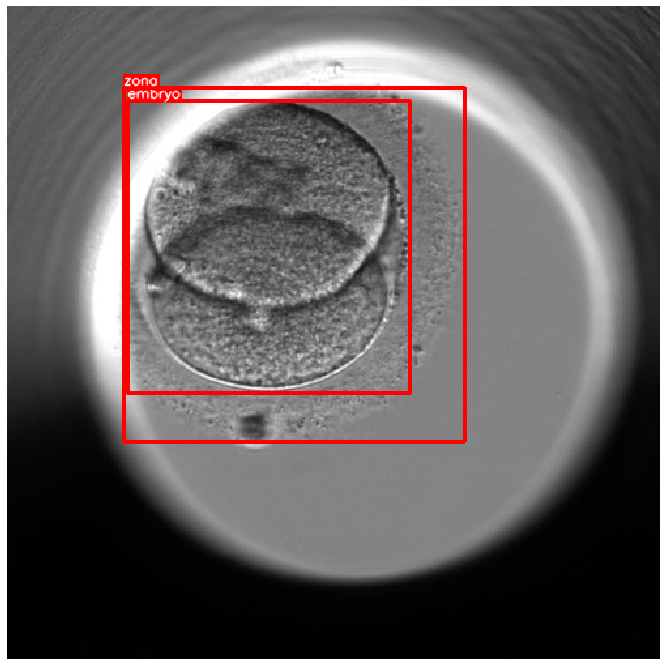

In [6]:
visualize(example, bboxes, class_labels, class_name_dict)

In [7]:
transform = A.Compose(
    [A.Rotate(limit=90, border_mode= cv2.BORDER_CONSTANT, value=0, p=1.0)],
    bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]),
)

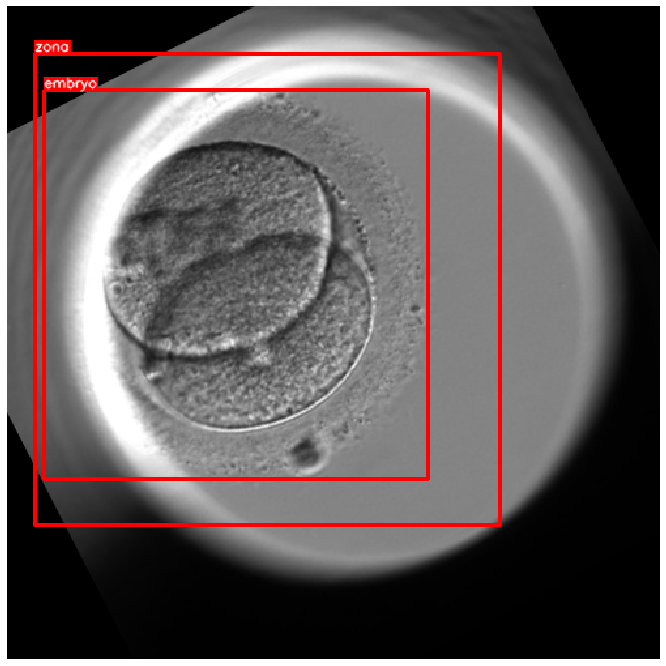

In [8]:
random.seed(7)
transform_example = transform(image = example, bboxes = bboxes, class_labels = class_labels)
visualize(transform_example['image'],
transform_example['bboxes'],
transform_example["class_labels"],
class_name_dict)

In [13]:
transform_example["image"].shape
transform_example['bboxes']

[(0.35145379198121807,
  0.42709013527501344,
  0.5888961183129506,
  0.5958251678153328),
 (0.39982550796320415,
  0.4337367203348825,
  0.7118872124931099,
  0.7205485243710874)]

In [14]:
cv2.imwrite("test_image.jpg", transform_example["image"])

True

In [17]:
f = open("test_bbox.txt", "a")
embryo = transform_example["bboxes"][0]
zona = transform_example["bboxes"][1]
f.write("0 {} {} {} {}".format(embryo[0], embryo[1], embryo[2], embryo[3]))
f.close()
f = open("test_bbox.txt", "a")
f.write("1 {} {} {} {}".format(zona[0], zona[1], zona[2], zona[3]))
f.close()

In [ ]:
random.seed(14)
try:
    transformed = transform(image=image, bboxes=bboxes,class_labels=class_labels)